Number of pre-filtered glasses: 13
Number of glasses dispensed: 230
Number of removed unsuccessful searches that were very close in time: 3
Number of pre-filtered glasses: 1
Number of unsuccessful searches: 27
Number of glasses used for clustering: 257


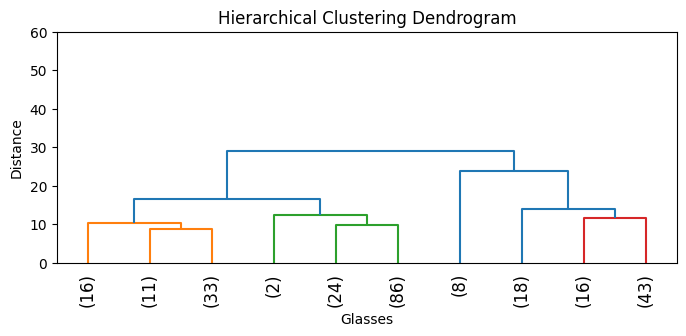

Number of removed unsuccessful searches that were same cluster and close in time: 1
cluster
1     48.0
2    109.0
3      0.0
4     73.0
Name: dispense_cluster_count, dtype: float64


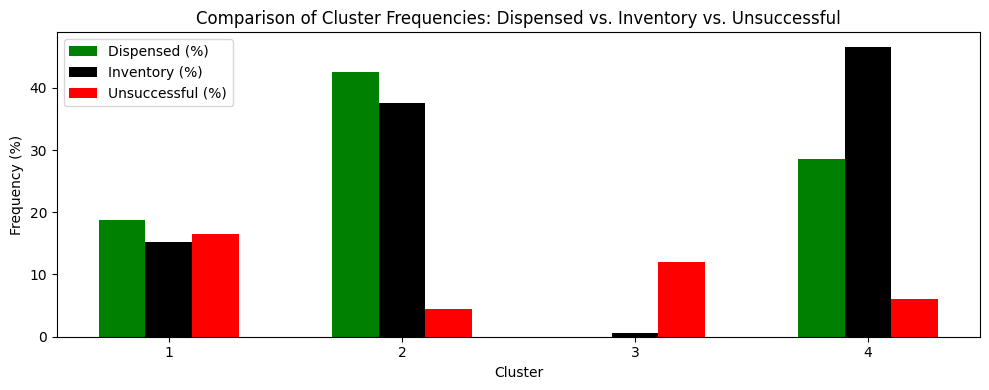

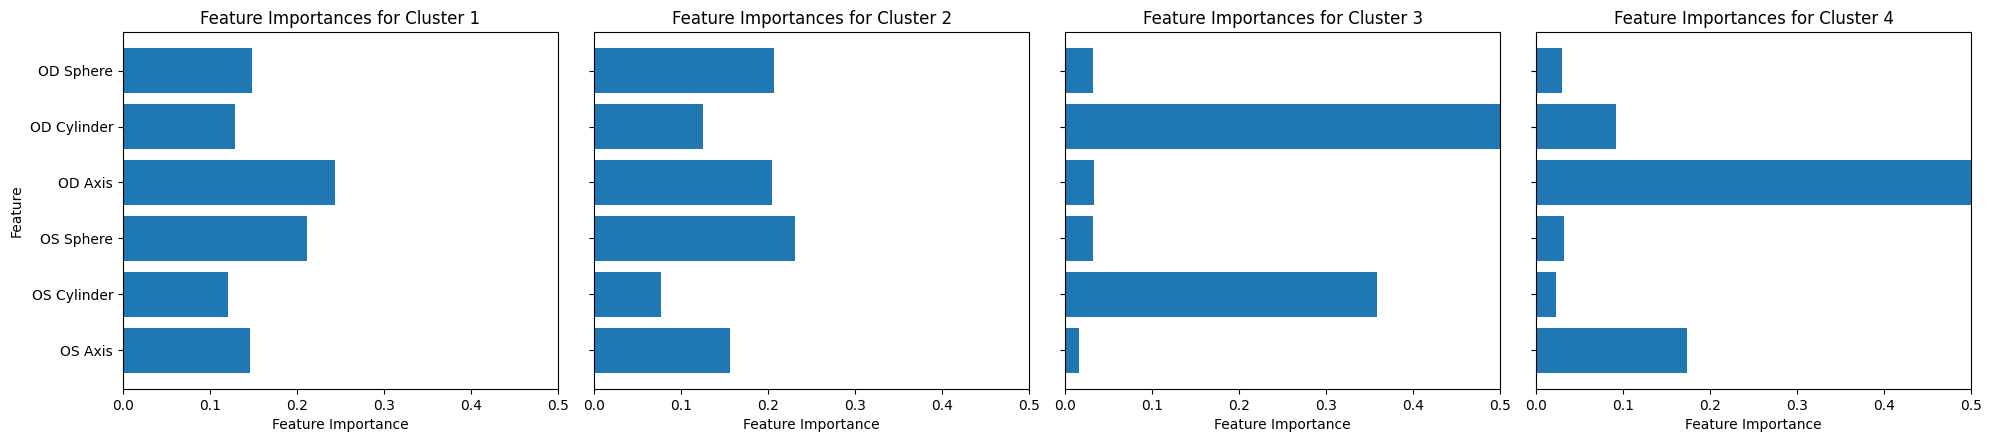

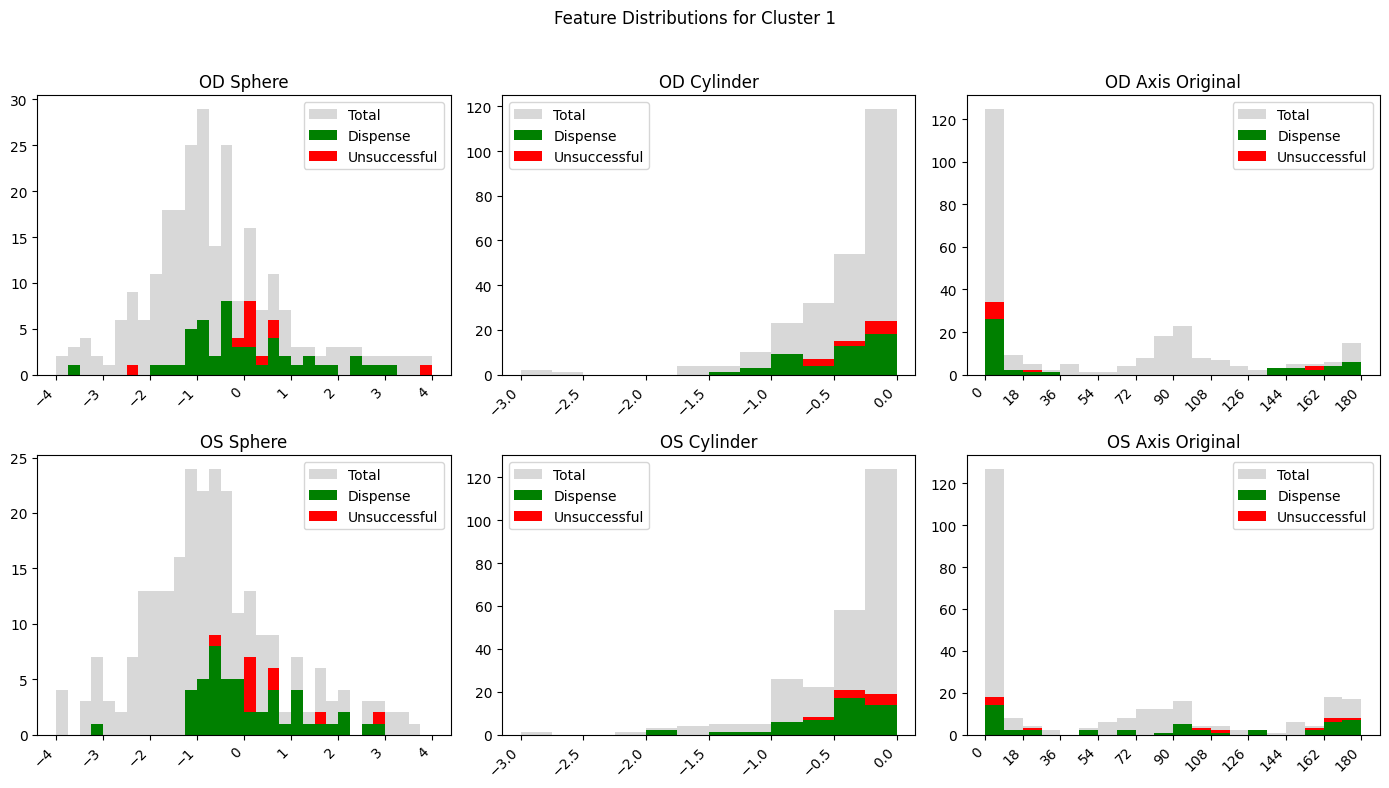

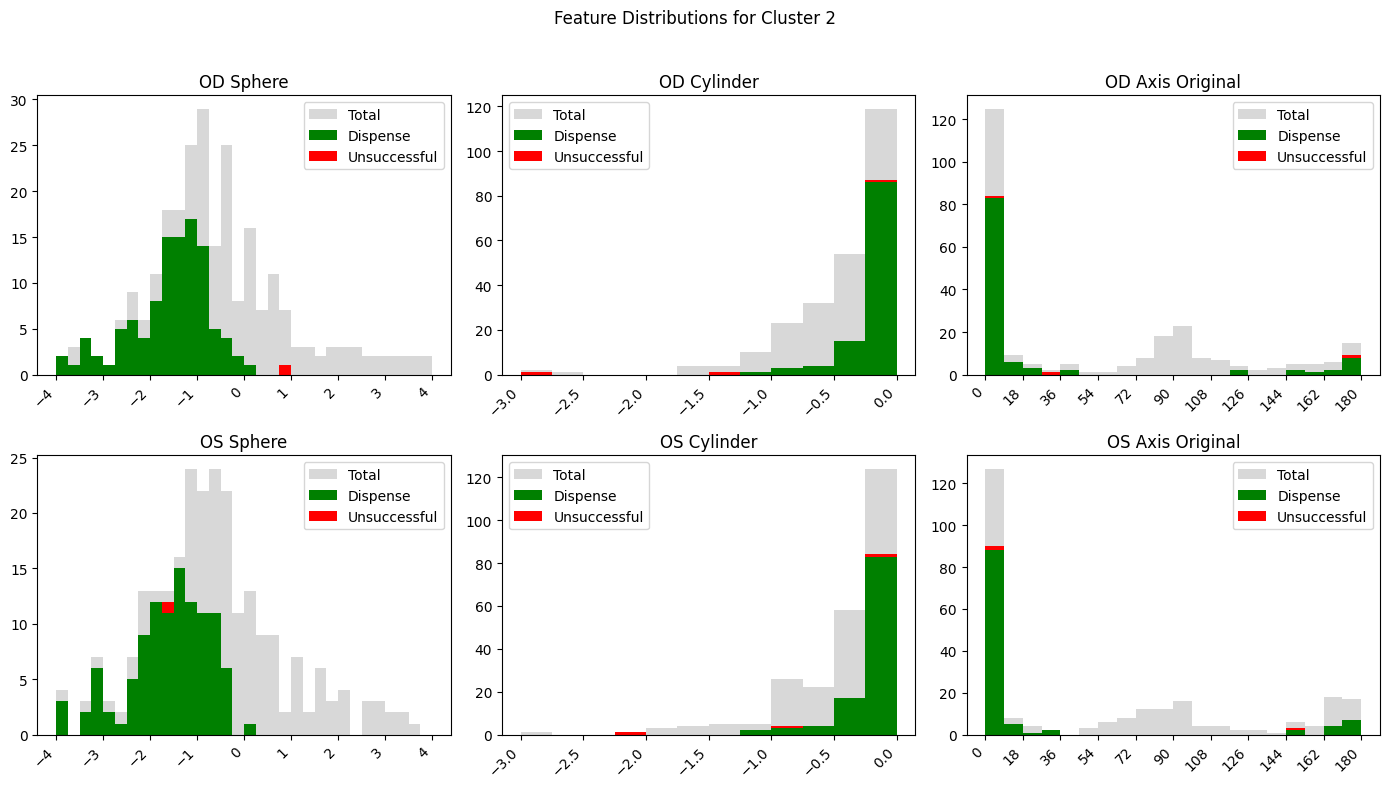

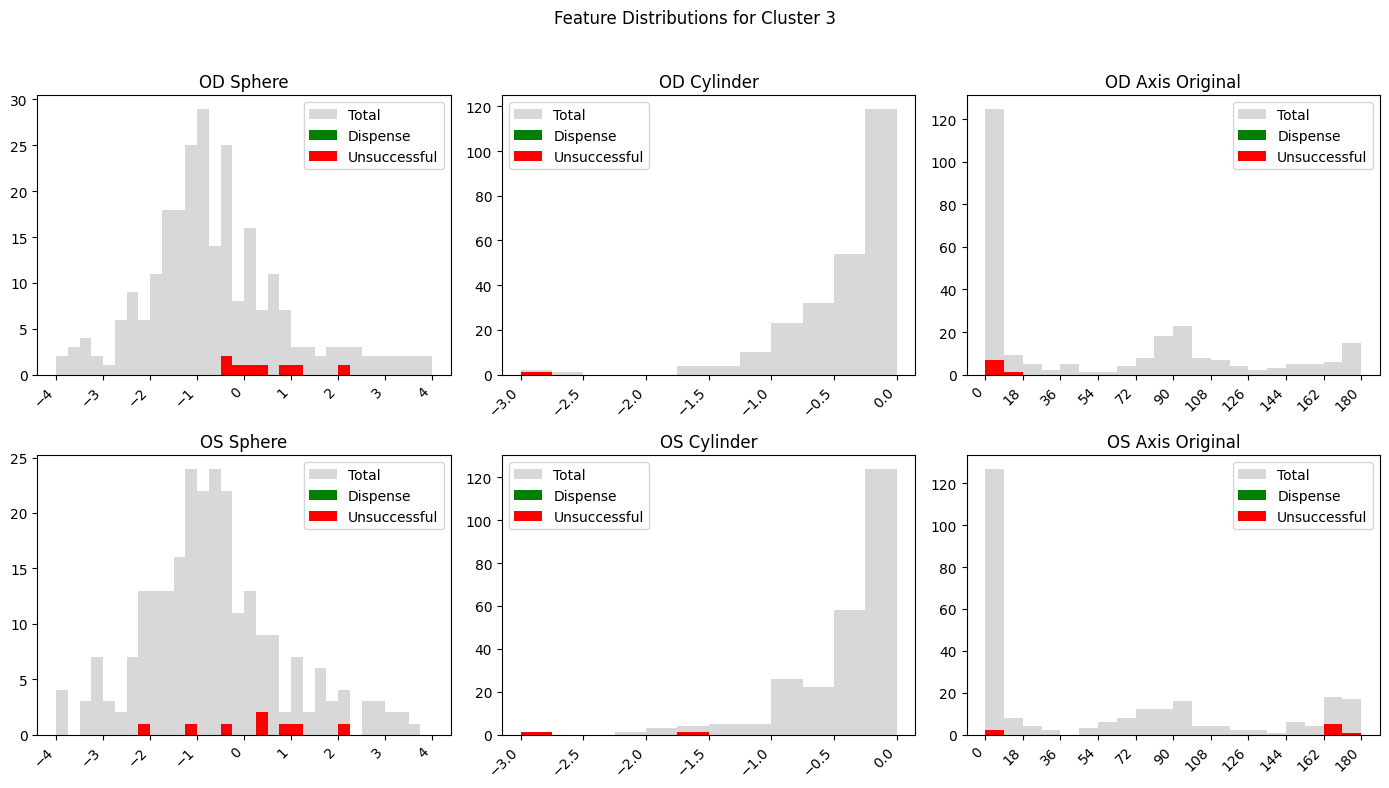

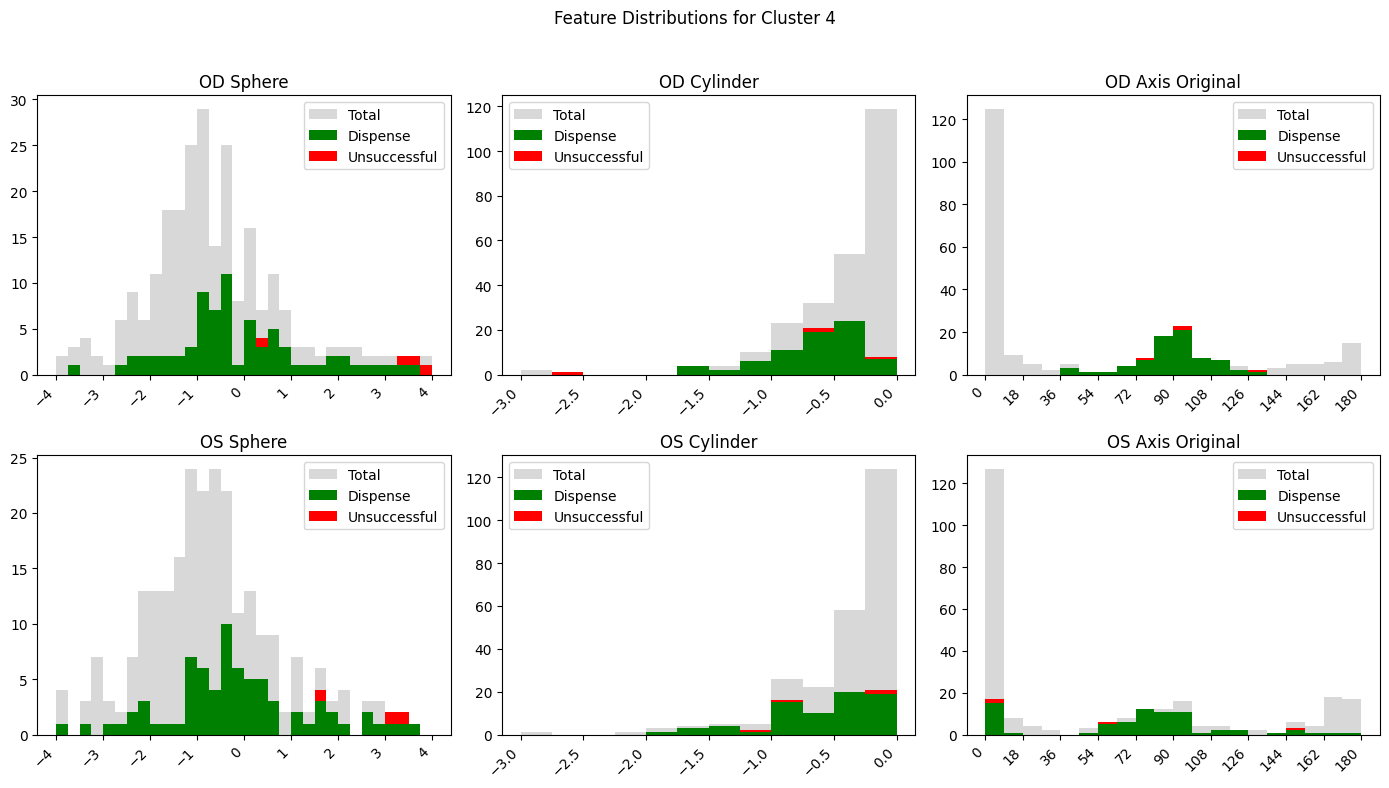

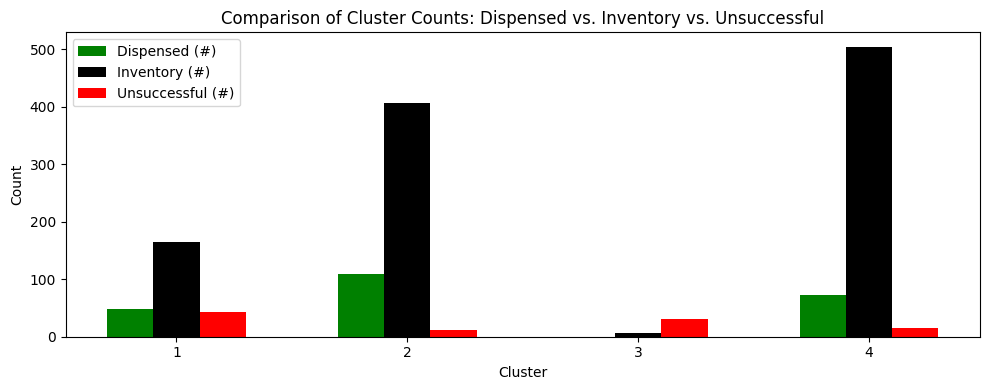

In [4]:
from analysis import launch
launch(False, 'sa', 4)

Number of pre-filtered glasses: 12
Number of glasses dispensed: 193
Number of removed unsuccessful searches that were very close in time: 15
Number of pre-filtered glasses: 6
Number of unsuccessful searches: 56
Number of glasses used for clustering: 249


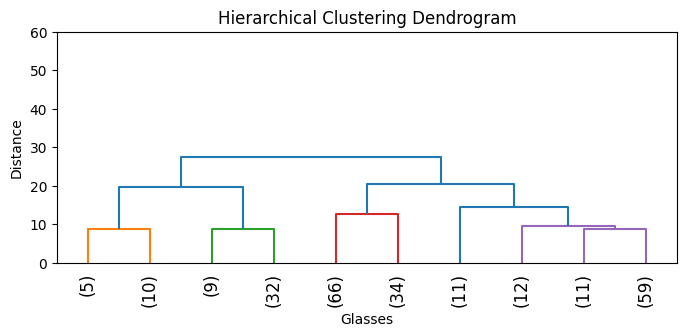

Number of removed unsuccessful searches that were same cluster and close in time: 8
cluster
1     6
2    40
3    88
4    59
Name: dispense_cluster_count, dtype: int64


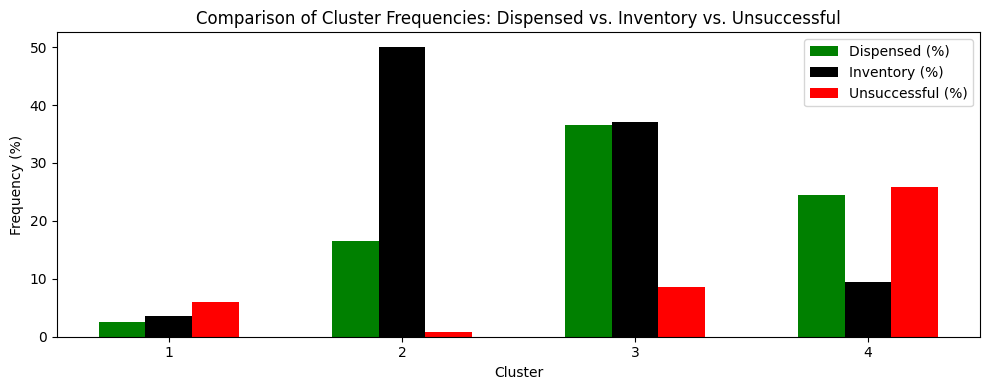

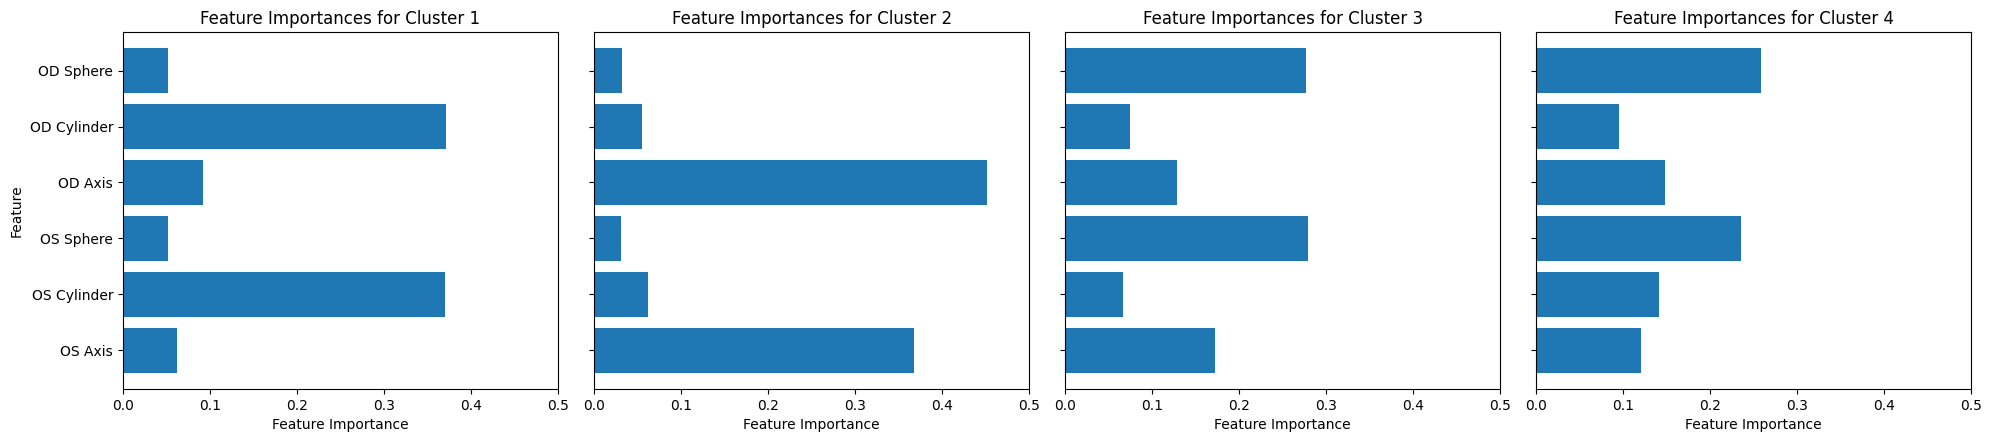

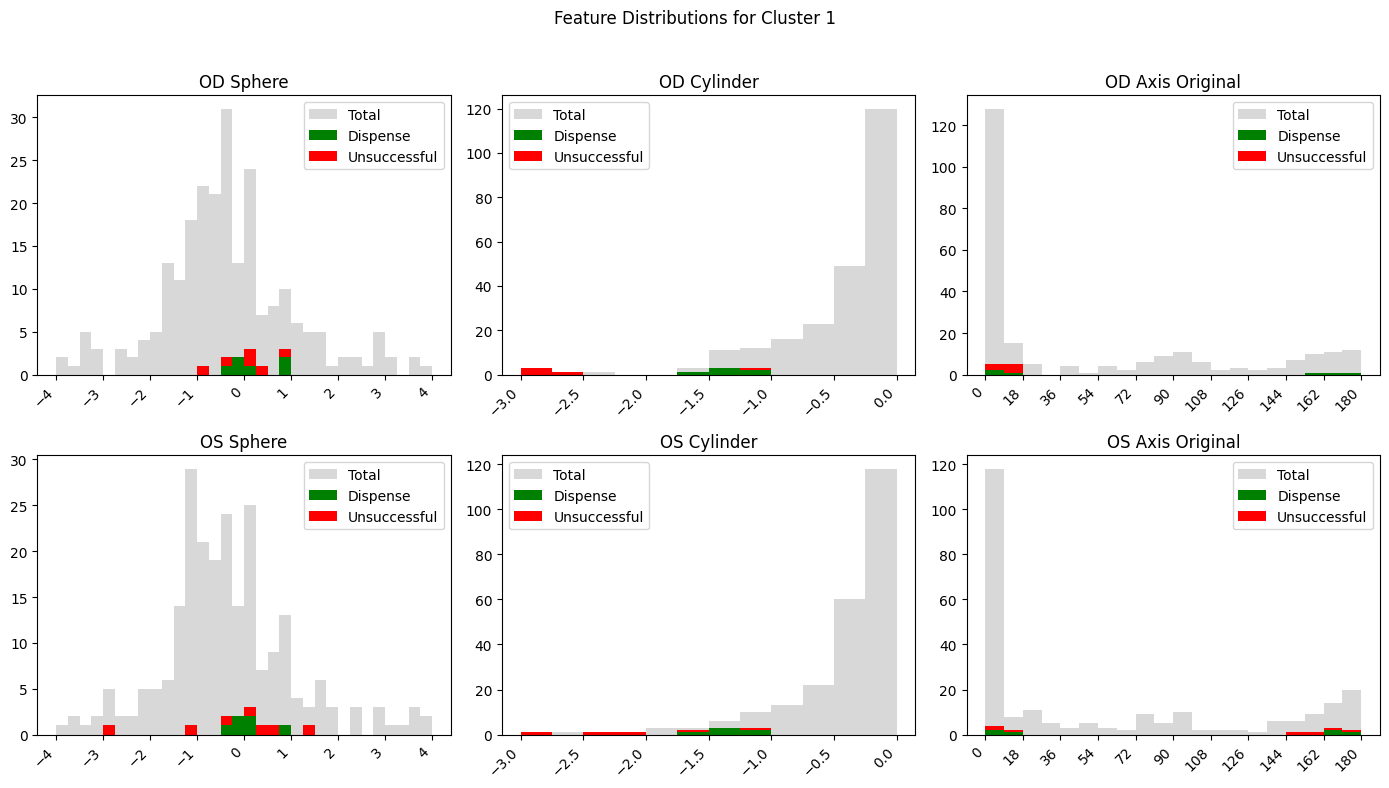

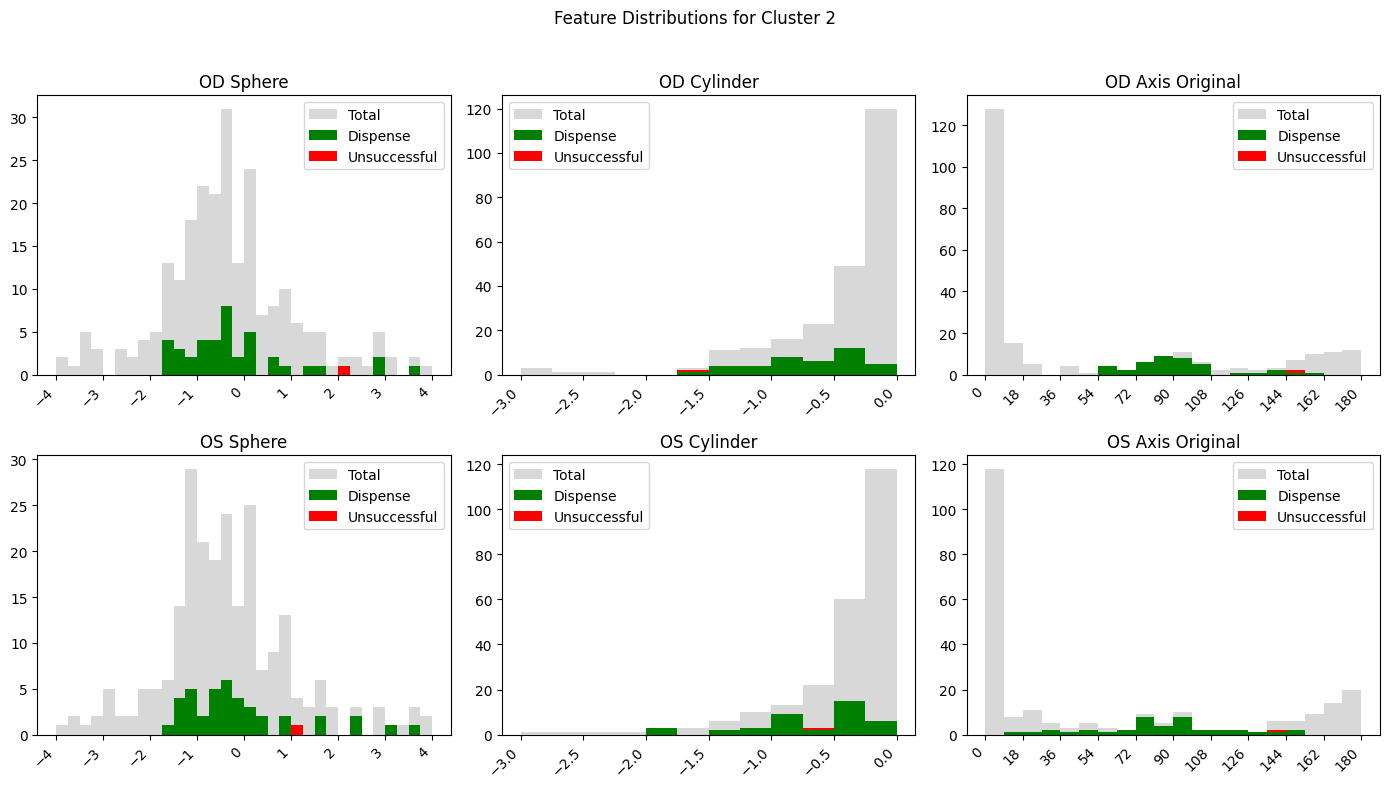

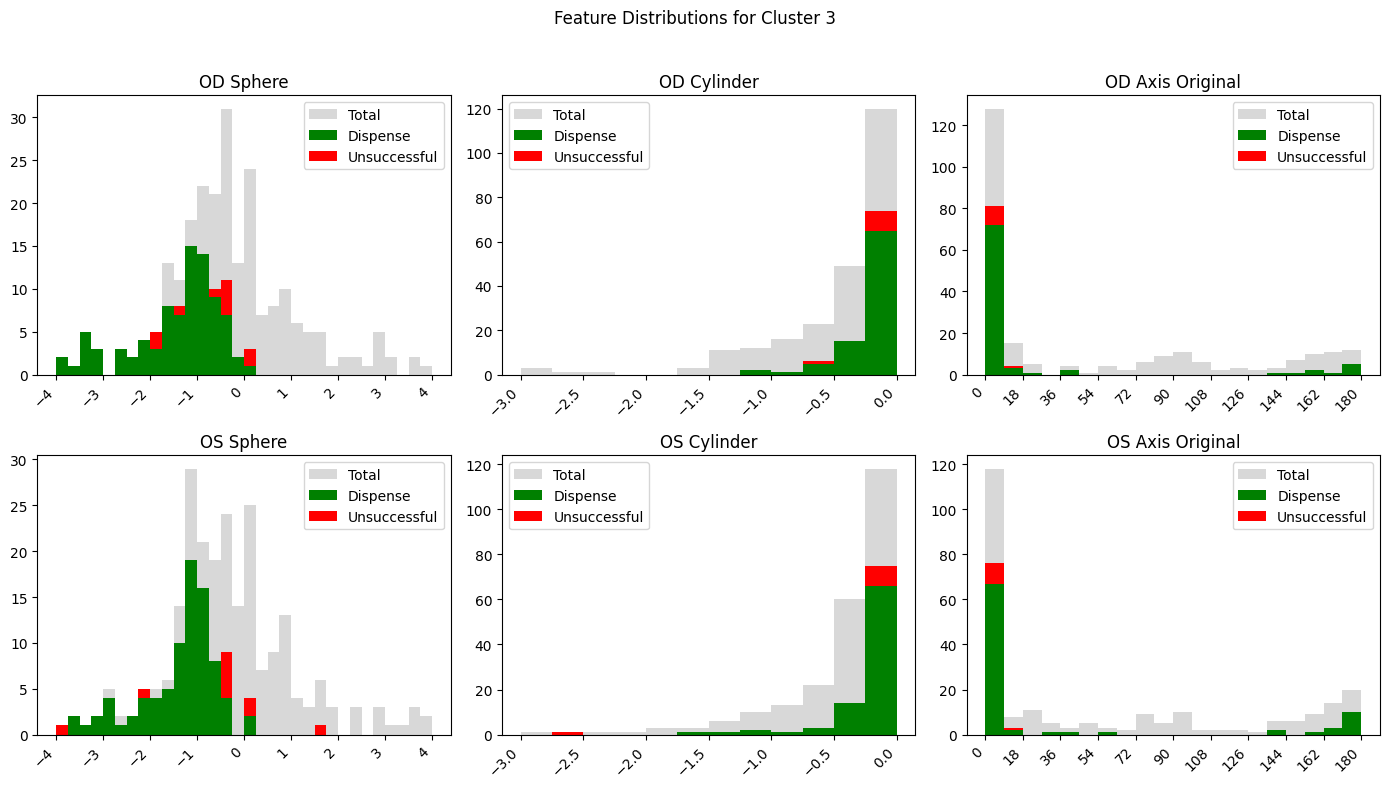

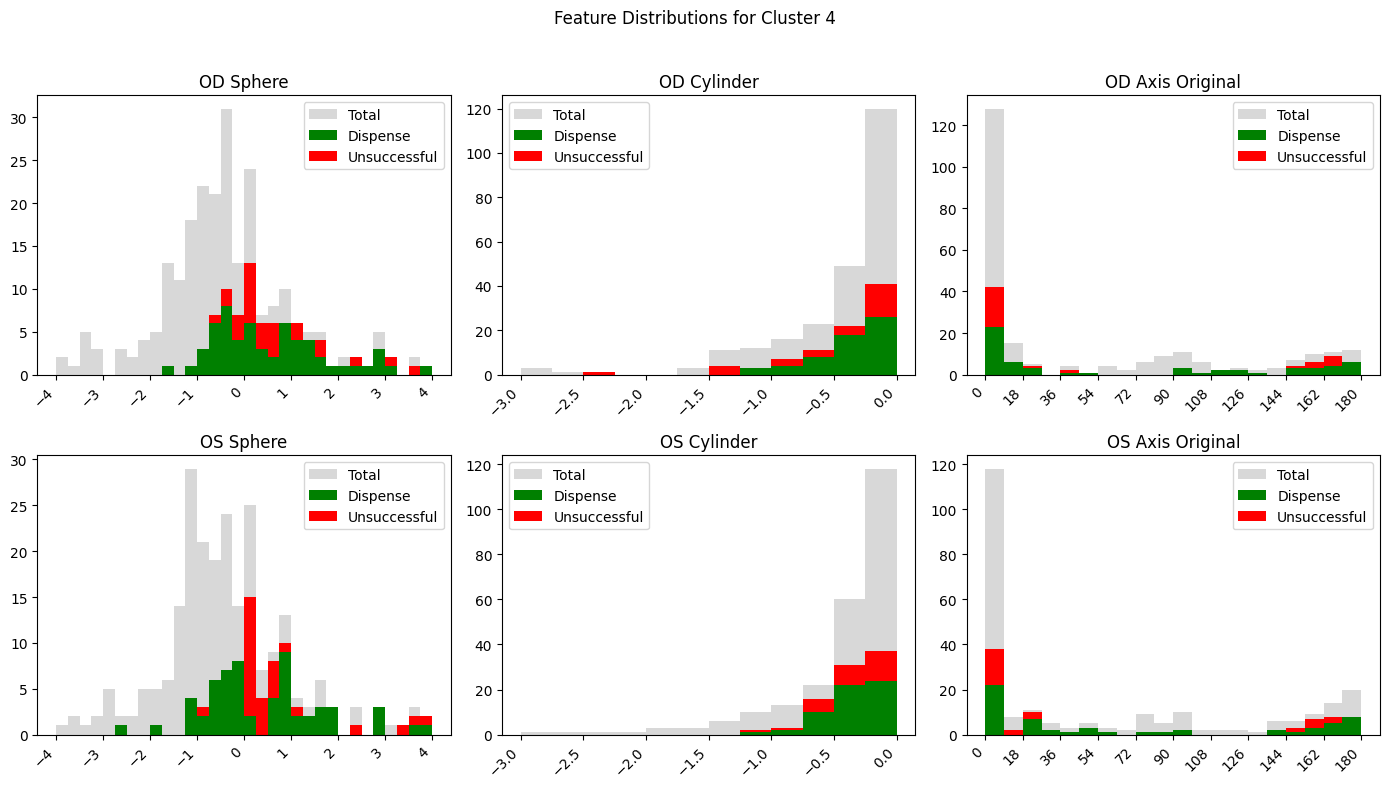

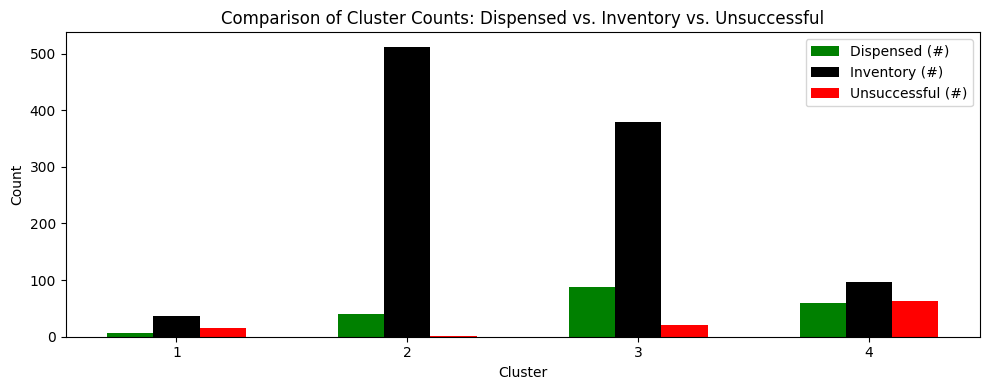

In [1]:
from analysis import launch
launch(False, 'sm', 4)

Number of pre-filtered glasses: 43
Number of glasses dispensed: 1023
Number of removed unsuccessful searches that were very close in time: 17
Number of pre-filtered glasses: 4
Number of unsuccessful searches: 70
Number of glasses used for clustering: 1093


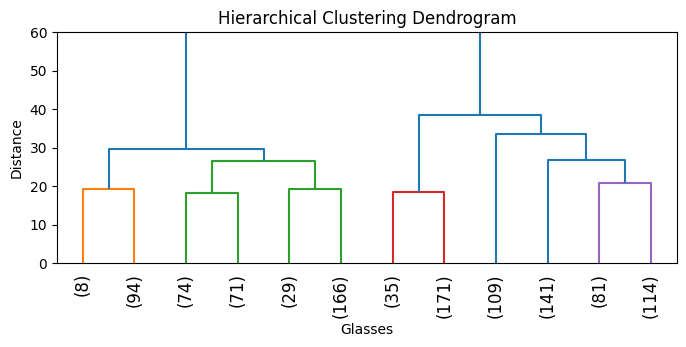

Number of removed unsuccessful searches that were same cluster and close in time: 5
cluster
1     89
2    340
3    187
4     92
5    315
Name: dispense_cluster_count, dtype: int64


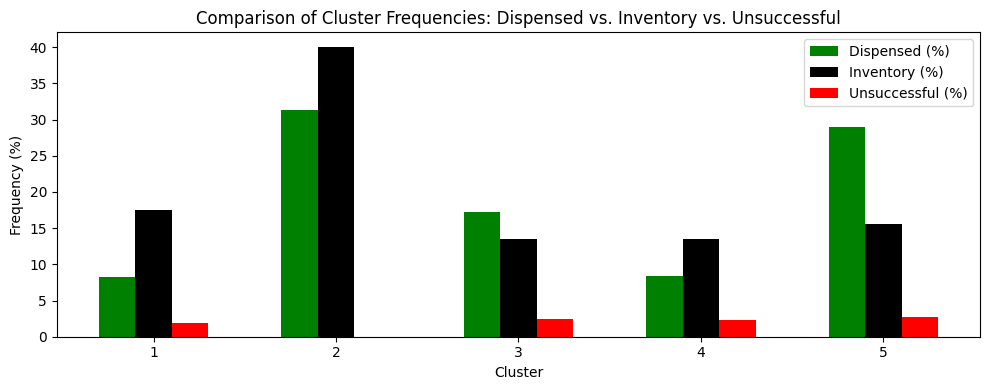

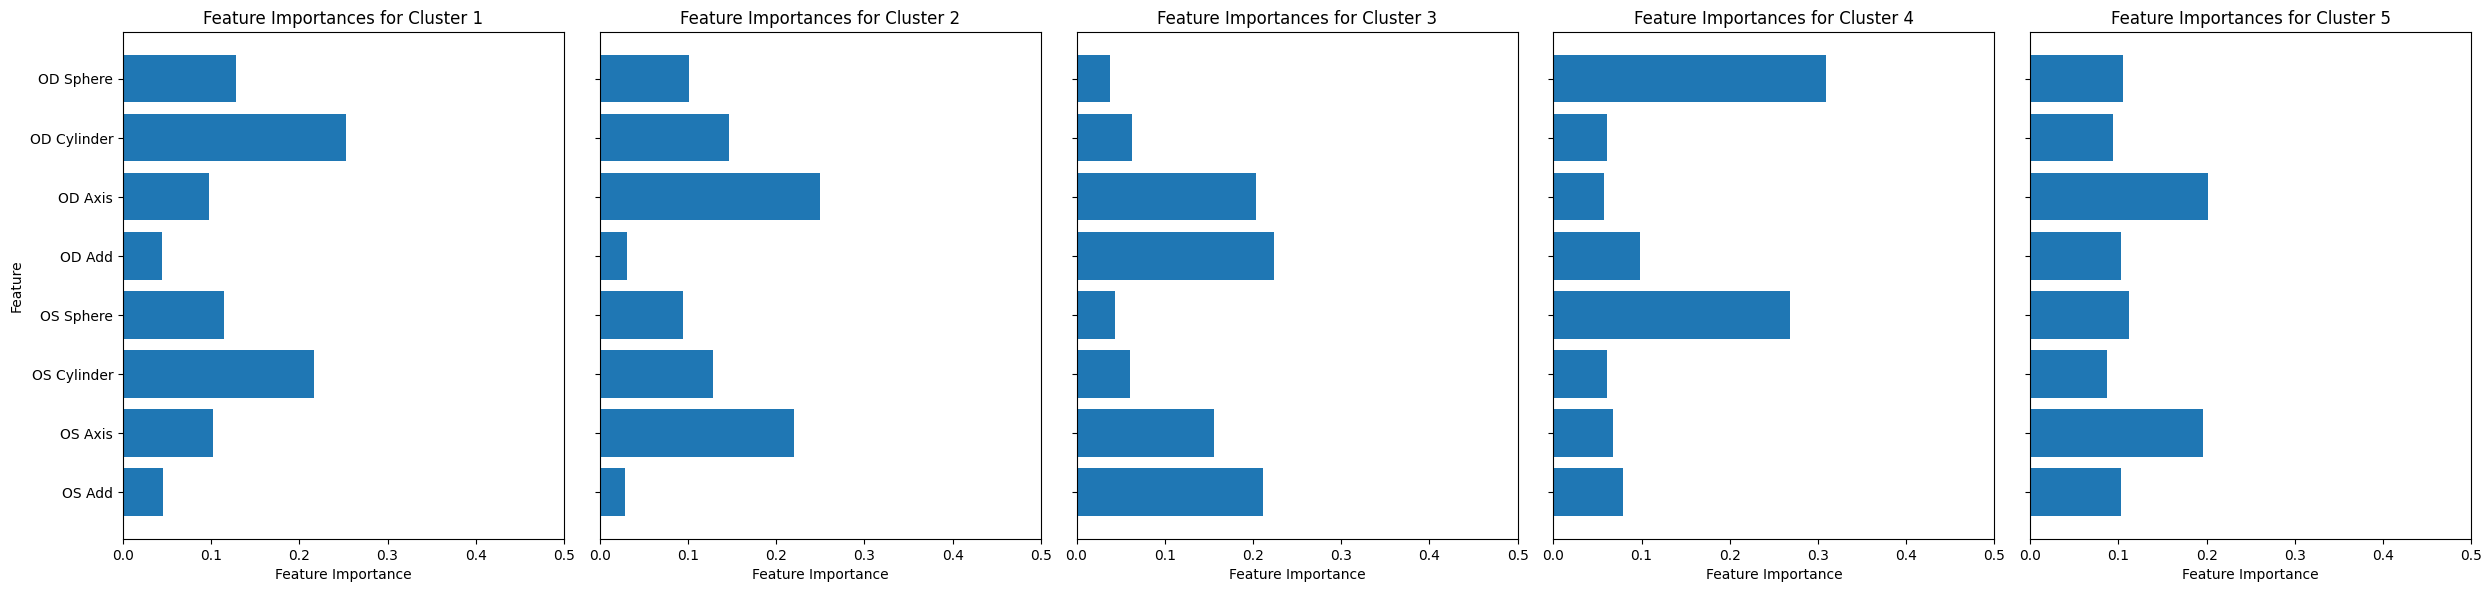

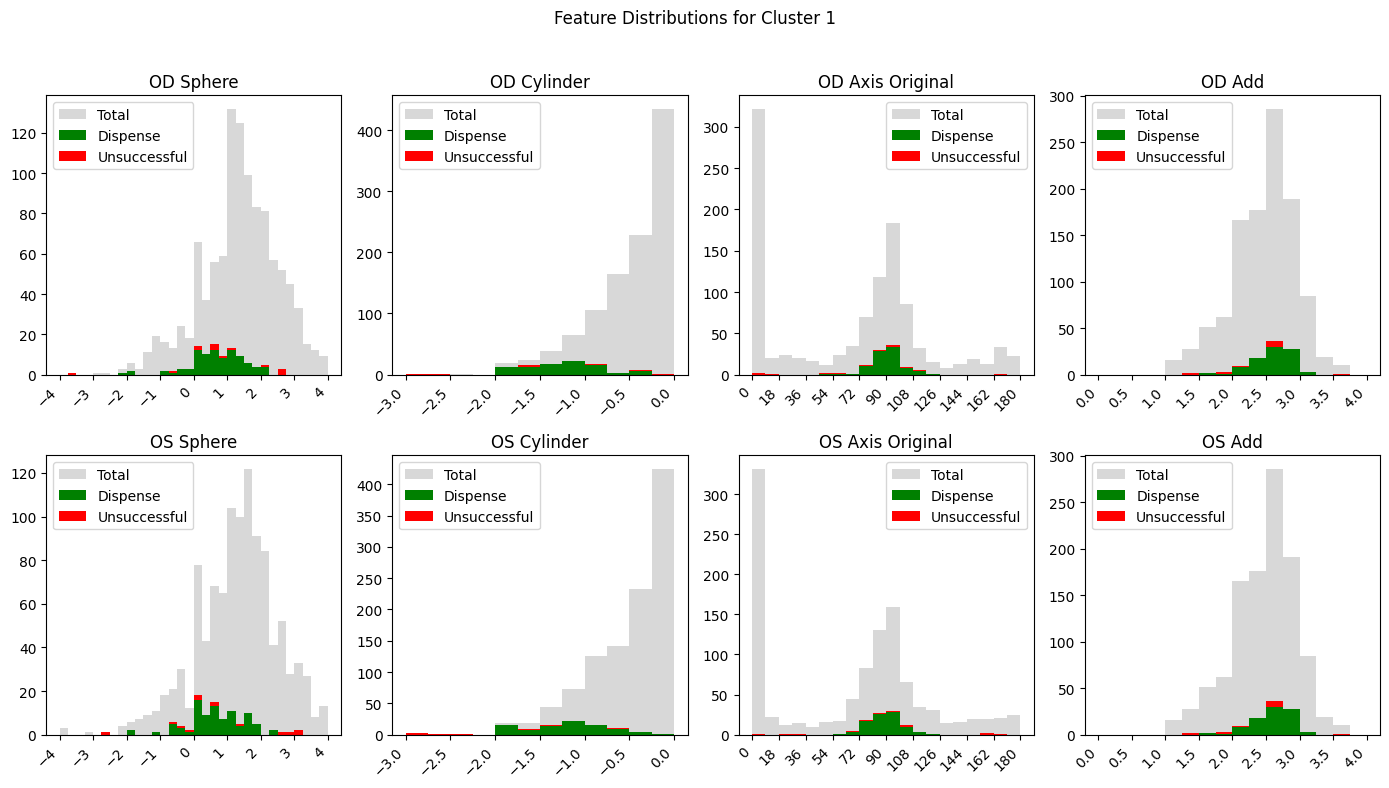

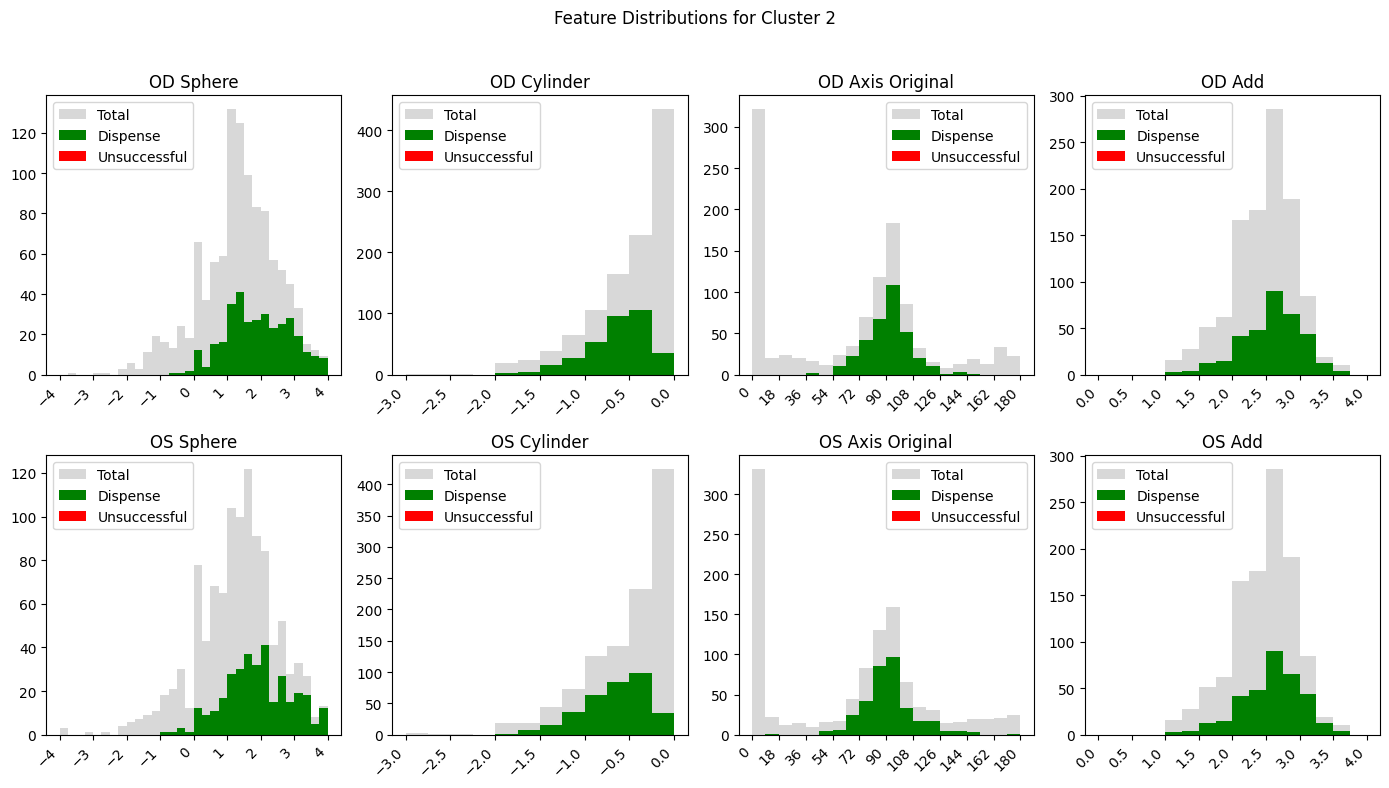

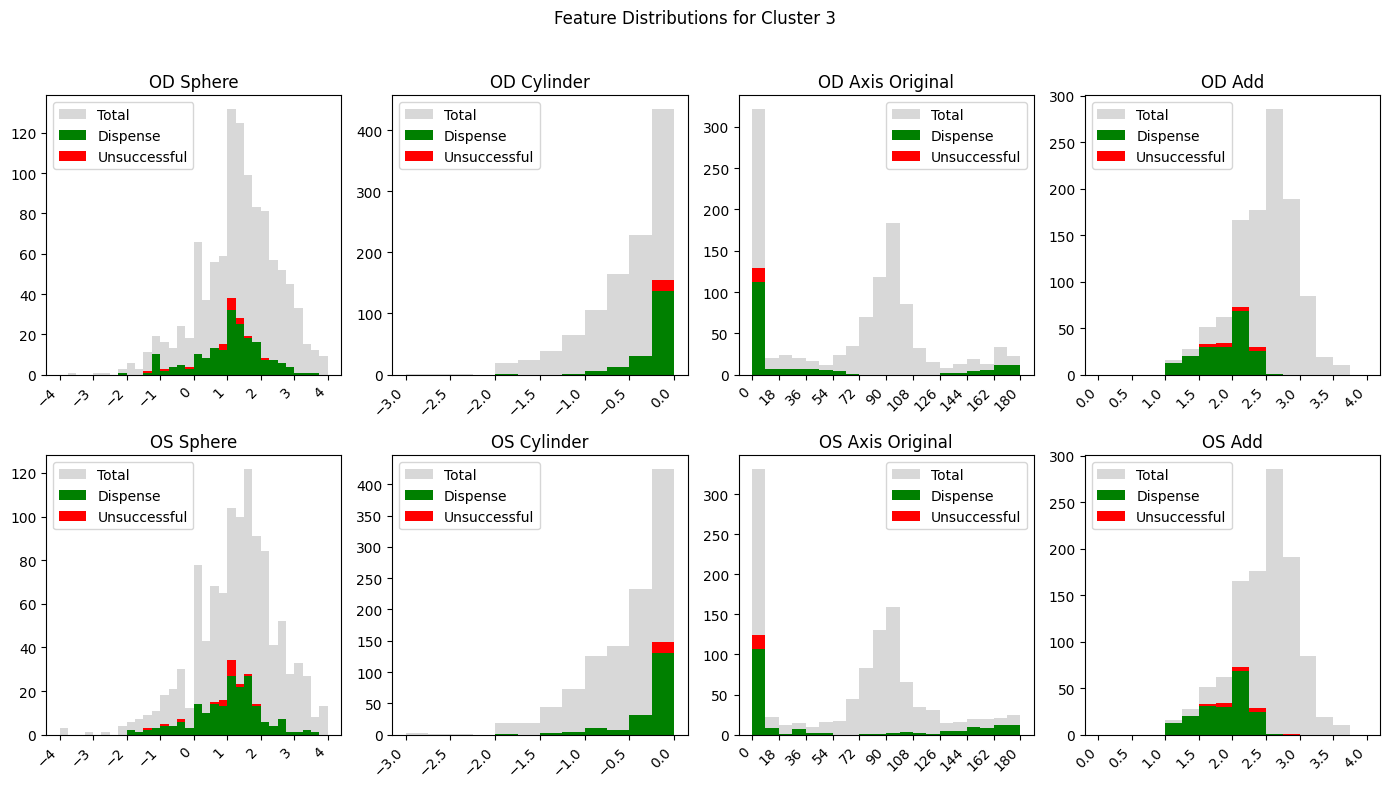

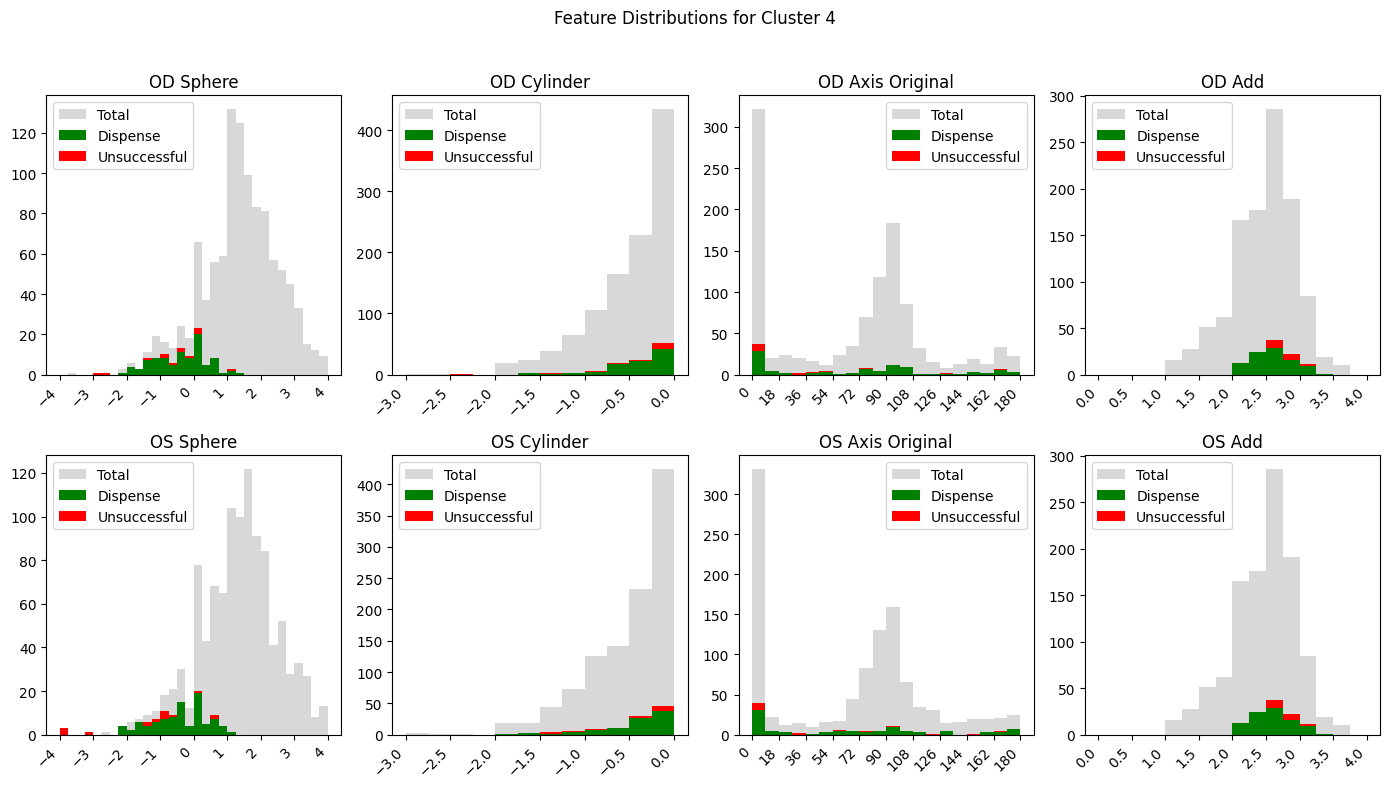

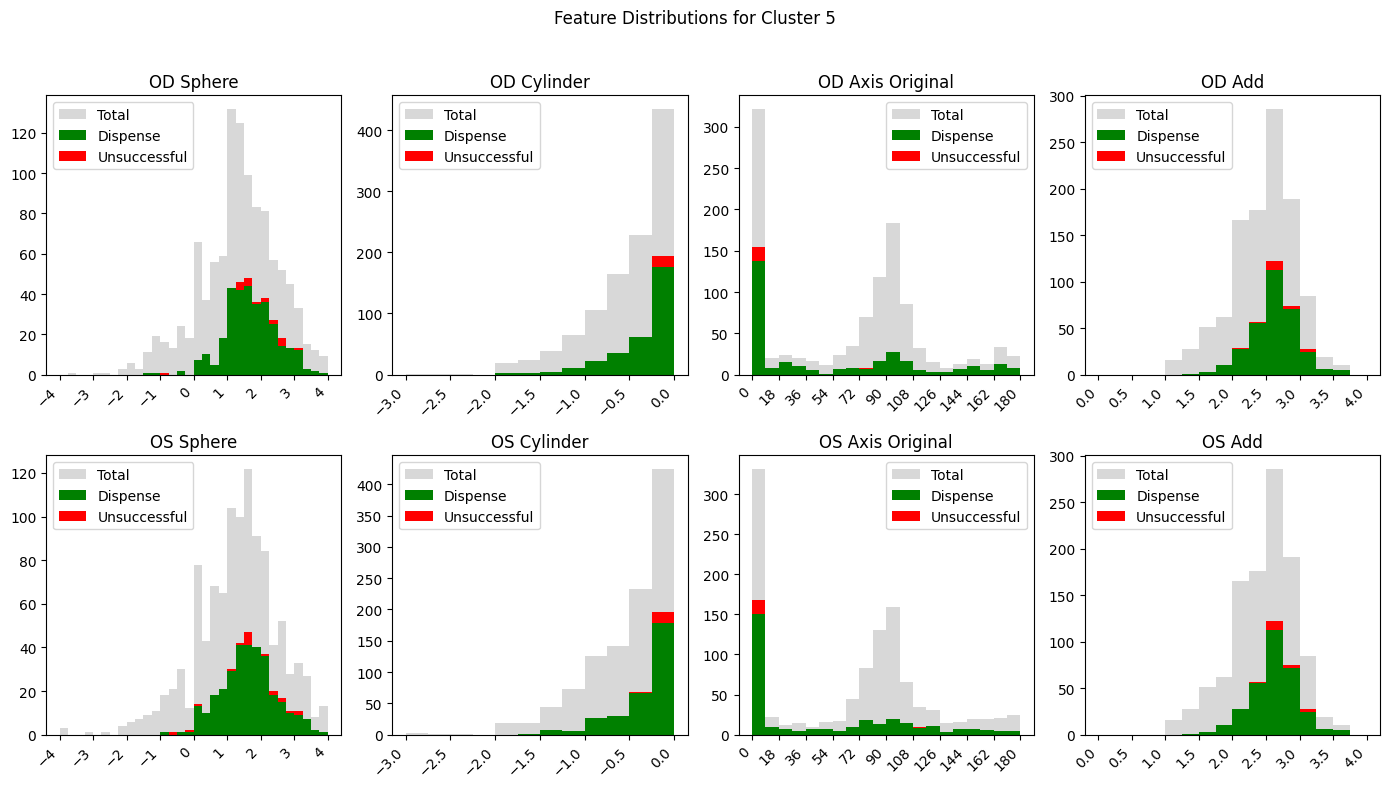

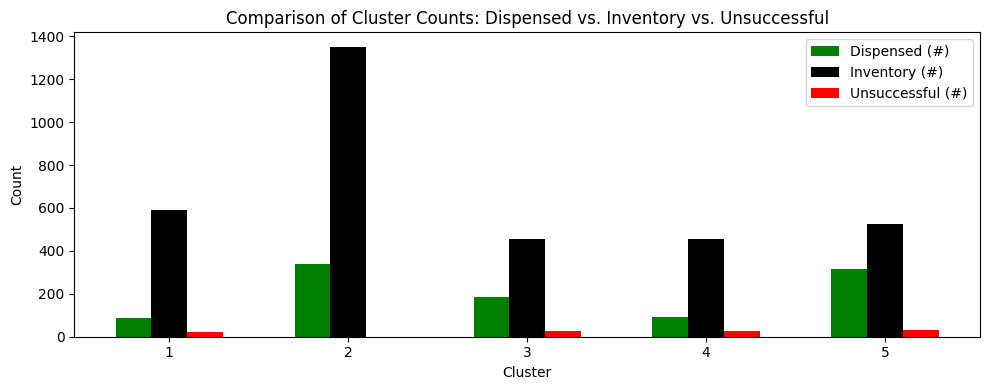

In [2]:
from analysis import launch
launch(True, 'sa', 5)

Number of pre-filtered glasses: 47
Number of glasses dispensed: 930
Number of removed unsuccessful searches that were very close in time: 29
Number of pre-filtered glasses: 10
Number of unsuccessful searches: 79
Number of glasses used for clustering: 1009


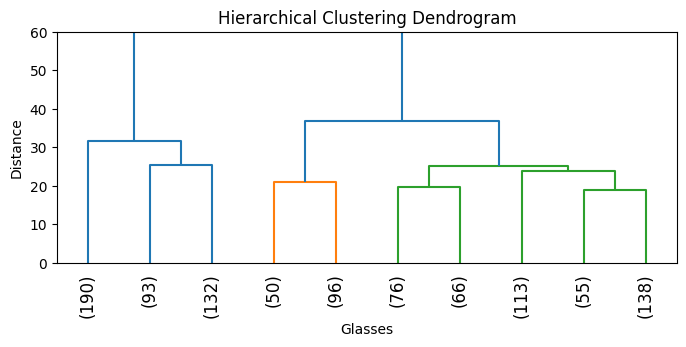

Number of removed unsuccessful searches that were same cluster and close in time: 11
cluster
1    188
2    214
3    137
4    391
Name: dispense_cluster_count, dtype: int64


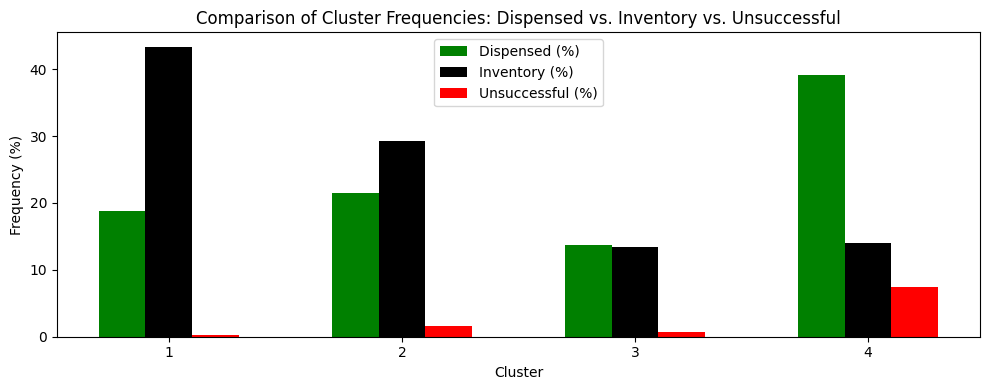

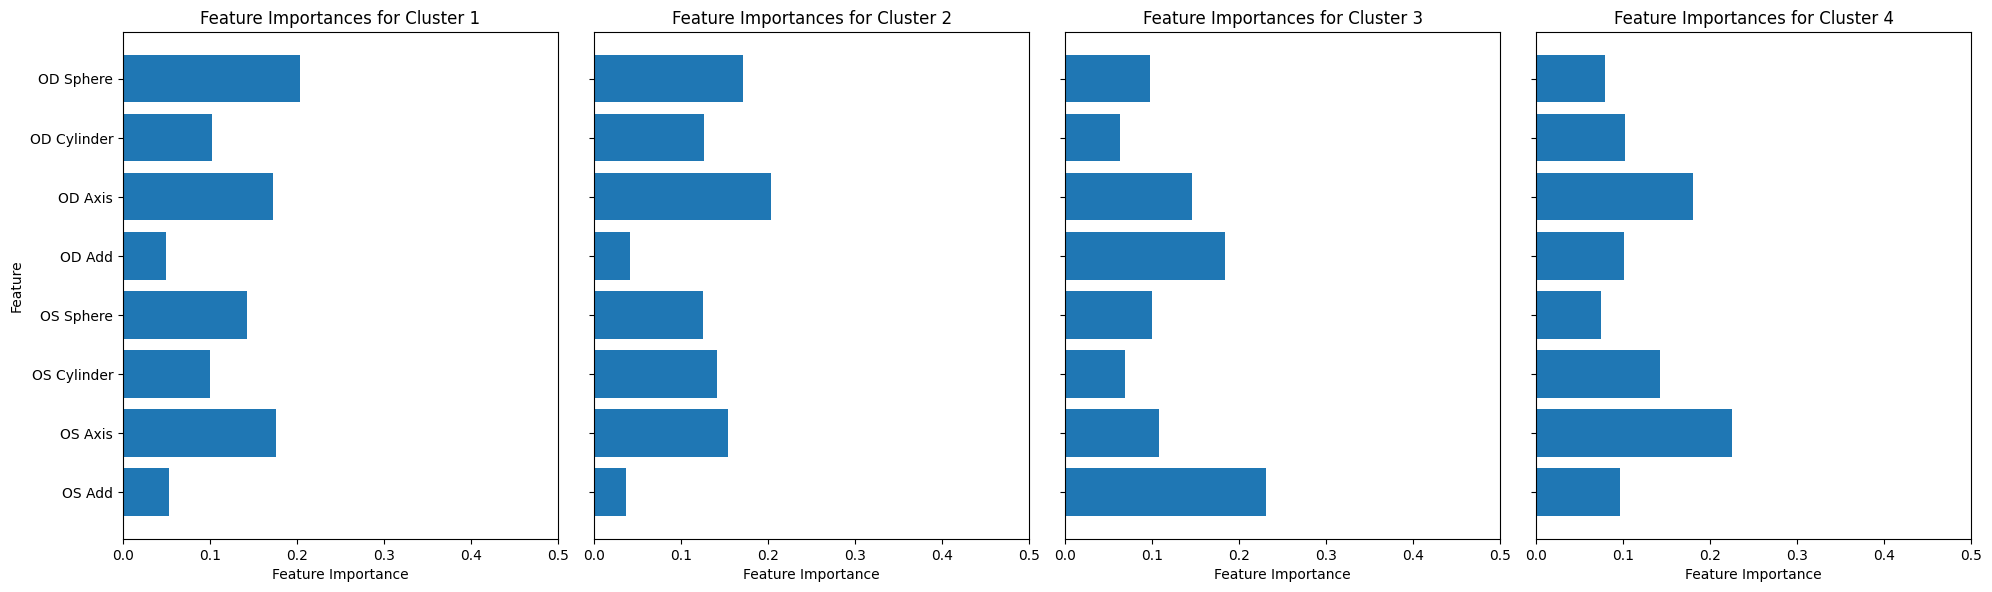

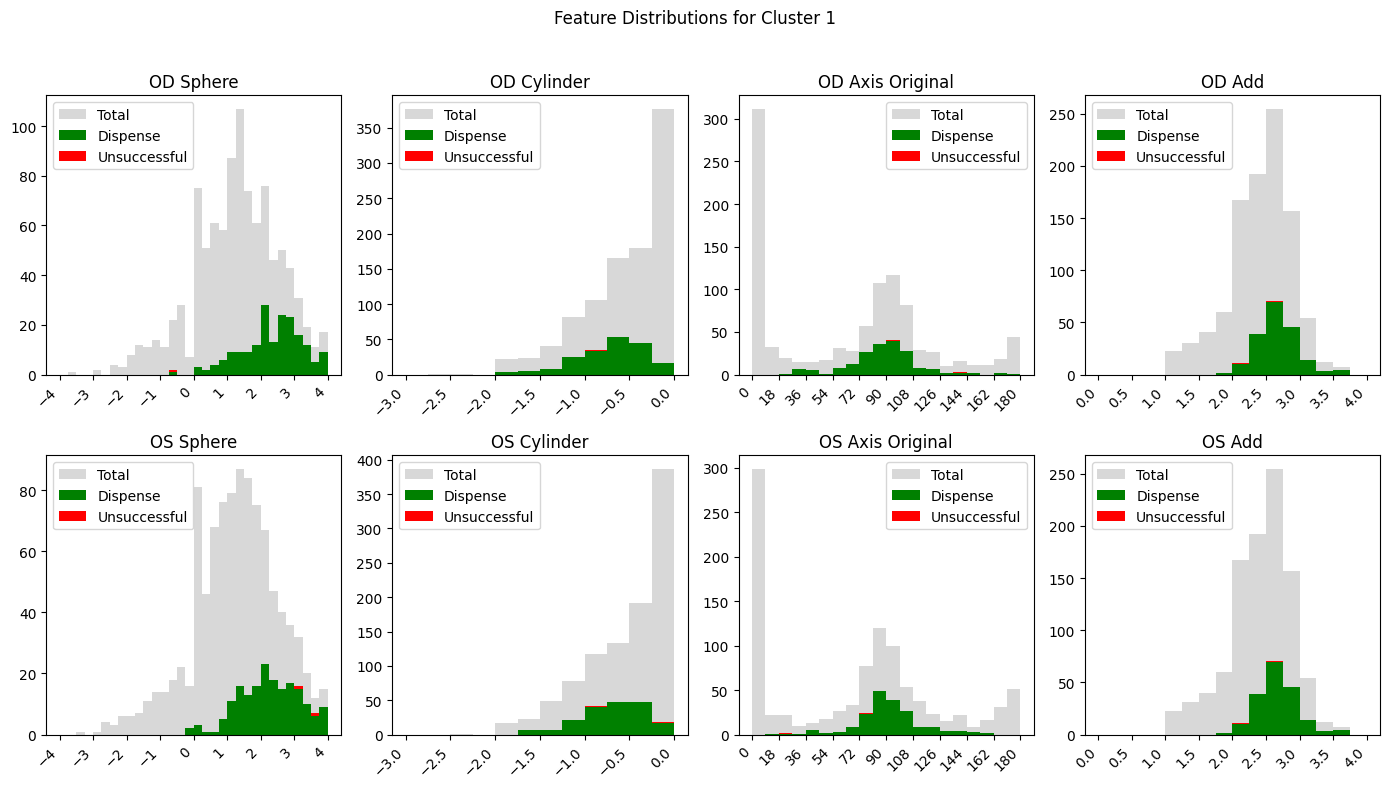

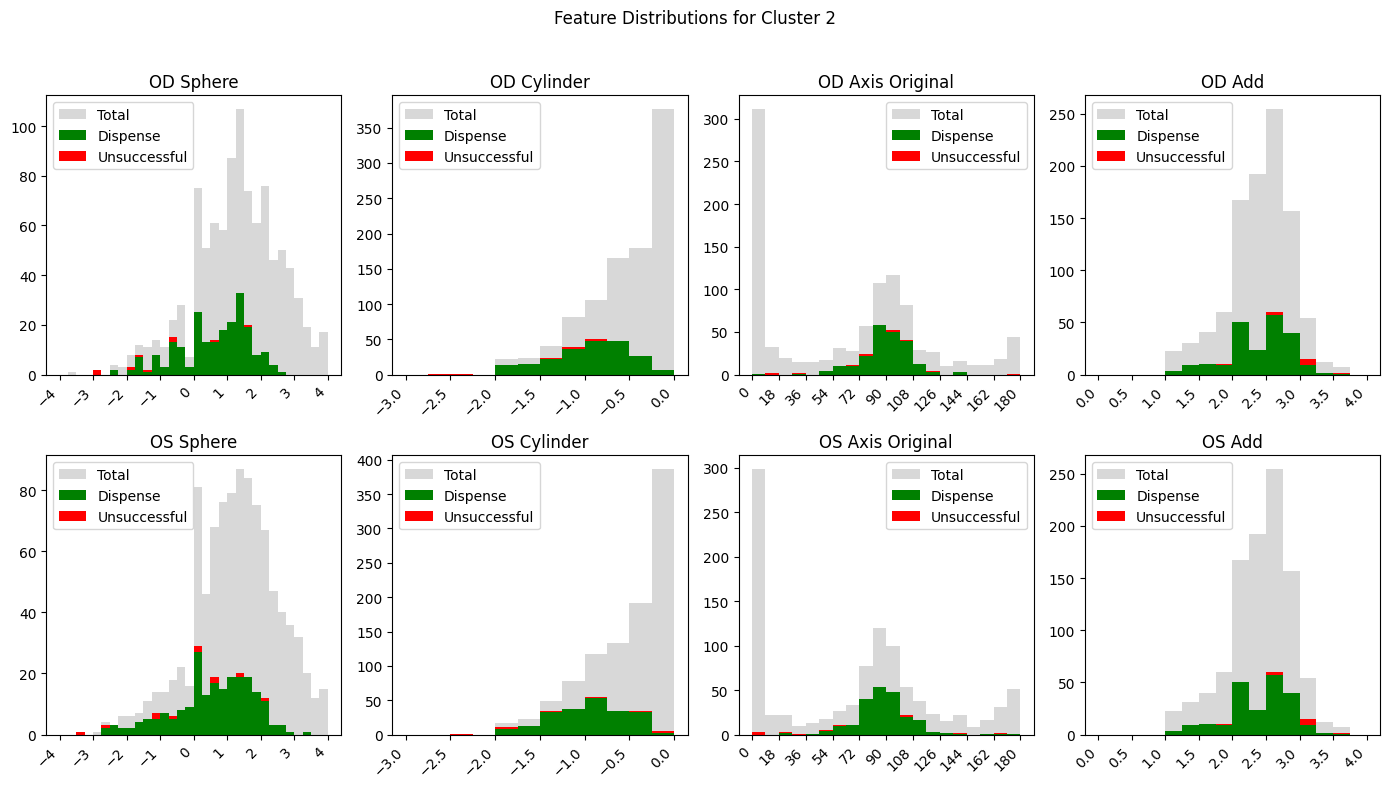

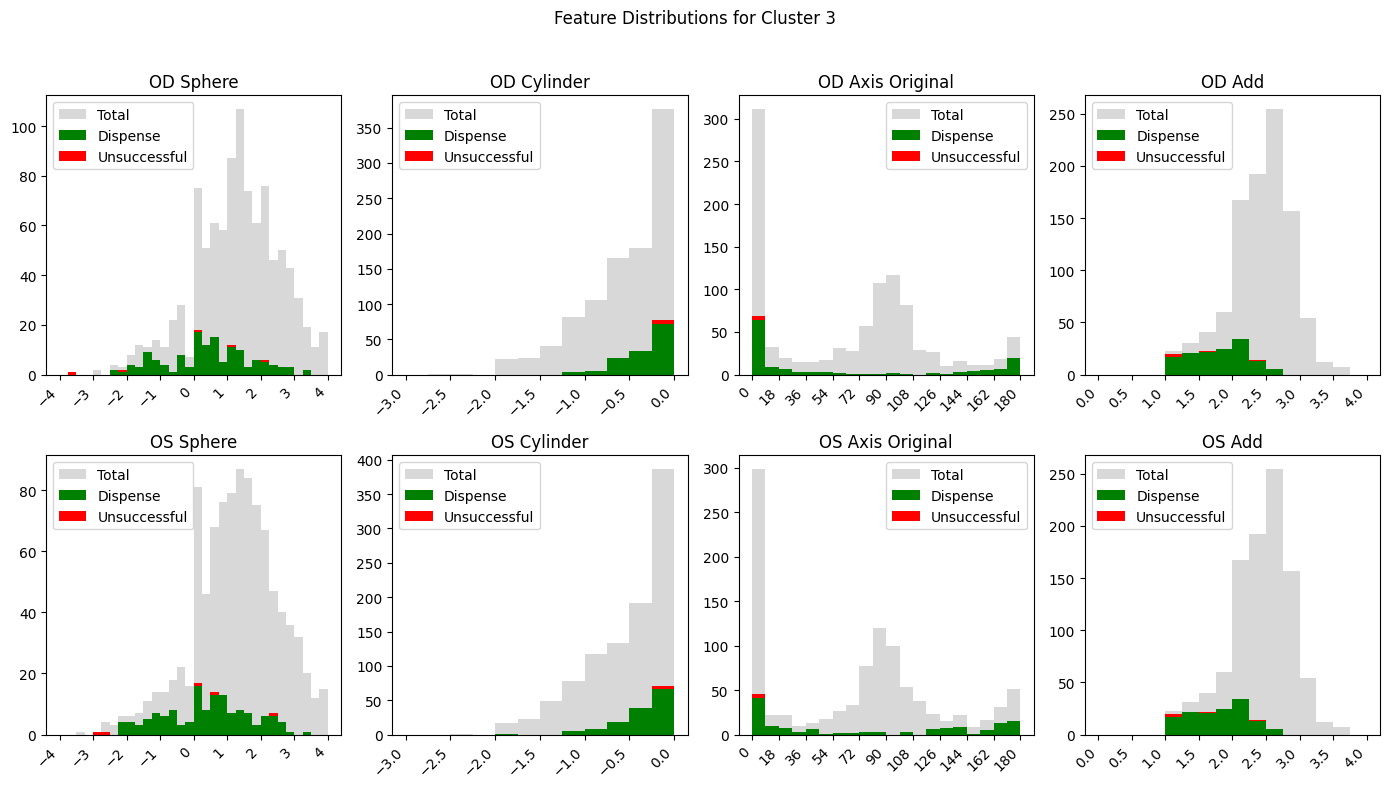

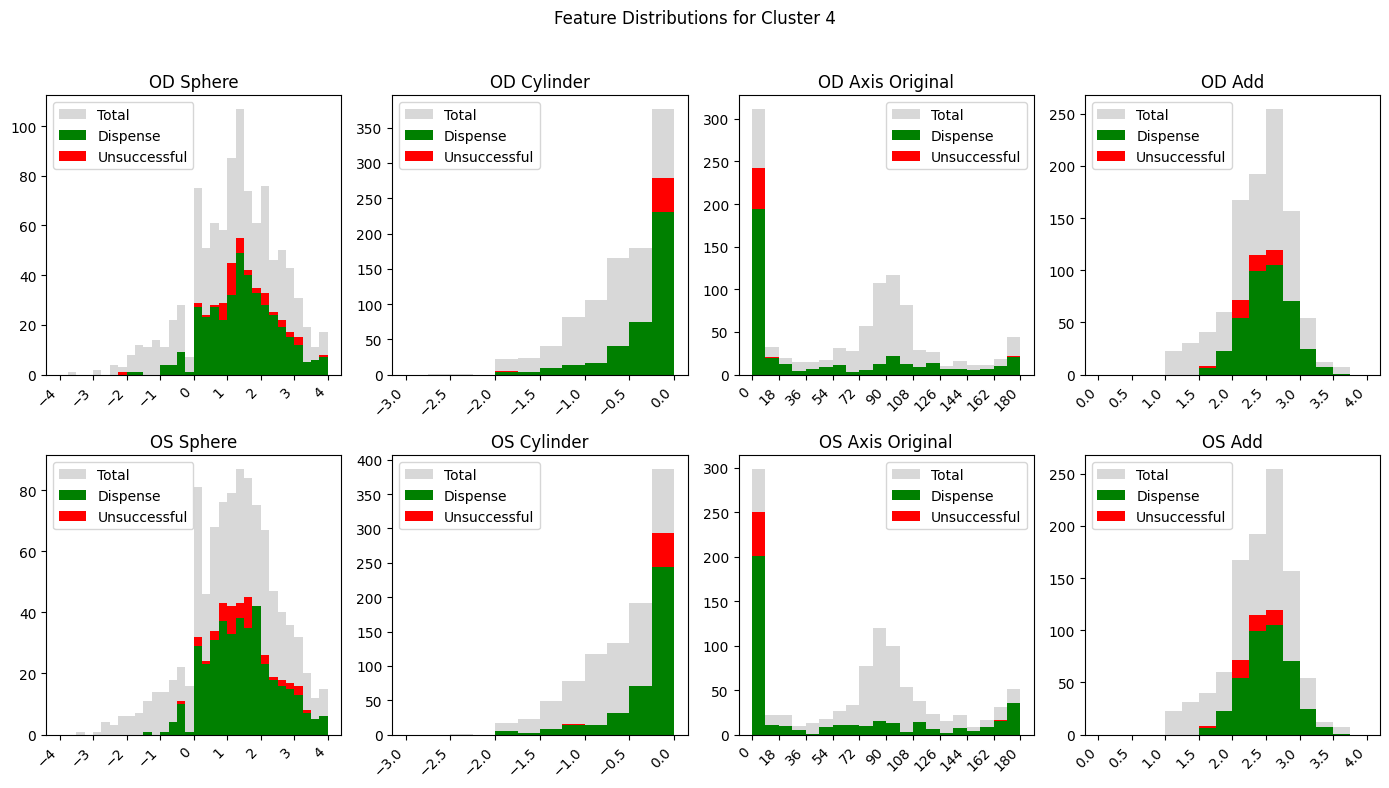

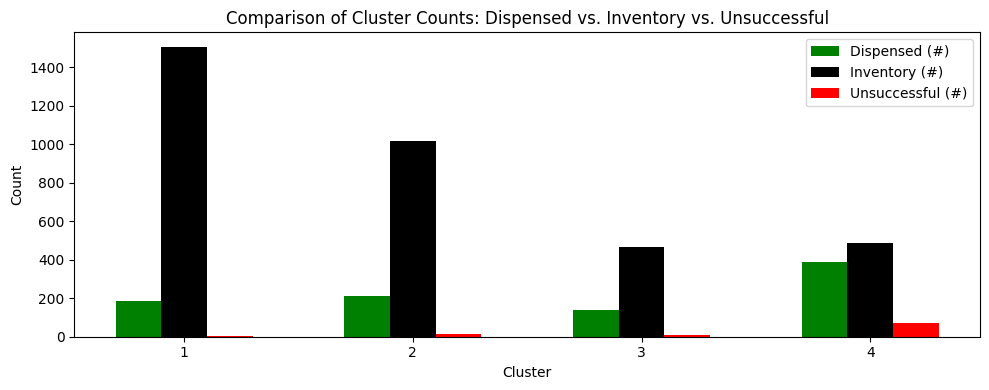

In [3]:
from analysis import launch
launch(True, 'sm', 4)